### Import modules

In [142]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors 
import matplotlib.cm as cm

import h5py 
import glob
import os 
import pickle

from datetime import datetime
import pytz

import scipy
from scipy.fftpack import fft,ifft 
from scipy.linalg import svd
import pywt

# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.matlab2python as mat2py
import icewave.tools.matlab_colormaps as matcmaps
import icewave.tools.Fourier_tools as FT
import icewave.das.DAS_package as DS
import icewave.sebastien.set_graphs as set_graphs
import icewave.tools.rw_data as rw

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rcParams.update({
    "text.usetex": True}) # use latex

global g
g = 9.81
global date_downsampling 
date_downsampling = ['0210','0212']
global down_sampling_factor
down_sampling_factor = 10

full_blues = mpl.colormaps['Blues'].resampled(256)
new_blues = colors.ListedColormap(full_blues(np.linspace(0.2,1,256)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Function section 

In [143]:
#%% FUNCTION SECTION 

def plot_spatio_temp(spatio,fiber_length,extents,cmap):
    """ Plot spatio-temporal using specific format
    Inputs: - spatio, numpy 2D array [nt,nx],
            - fiber_length, float, length of fiber, as set in Febus software
    Outputs: - fig, matplotlib figure
             - ax, matplotlib axis object
             - imsh, matplotlib imshow object
             - cbar, matplotlib colorbar object """
    
    
    normalization = 'linear'
    fig,ax = plt.subplots()
    imsh = ax.imshow(spatio.T,origin = 'lower',aspect = 'auto',norm = normalization, cmap = cmap,
              interpolation = 'gaussian', extent = extents)
    ax.set_ylim([0,fiber_length])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = plt.colorbar(imsh,cax = cax)

    ax.set_xlabel(r'$t \; \mathrm{(s)}$',labelpad = 5)
    ax.set_ylabel(r'$x \; \mathrm{(m)}$',labelpad = 5)
    
    return fig,ax,imsh,cbar

#----------------------------------------------------------------------------------------------------

def shallow_hydroelastic(k,D,rho_w,H):
    """ Compute shallow hydroelastic dispersion relation
    Inputs: - k, numpy array, wavevector array
            - D, float  or numpy array, flexural modulus
            - rho_w, float or numpy array, water density
            - H, float or numpy array, water depth 
            
    Outputs : - omega, numpy array, pulsation given by shallow hydroelastic dispersion relation """
    
    omega = np.sqrt((g*k + D/rho_w*k**5)*np.tanh(H*k))
    
    return omega

#-------------------------------------------------------------------------------------------------------

def get_water_height(DAS_water_height,UTC_t,selected_x):
    """ Compute water height for a given UTC datetime and position along the fiber
    Input : - DAS_water_height, dictionnary containing recording of water depth evolution during the whole experiment 
            - UTC_t, datetime object, time at which we look for water height
            - selected_x, float, position along optical fiber in meter 
    Output : H, float, water height at the selected time and position 
    """

    closest_idx = np.argmin(abs(UTC_t - DAS_water_height['UTC_t']))
    closest_idx_pos = np.argmin(abs(selected_x - DAS_water_height['s']))
    H = DAS_water_height['water_height'][closest_idx_pos,closest_idx]
    return H

#-------------------------------------------------------------------------------------------------------

def subpixel_polyfit(x,y,p,deg = 2):
    """ Compute subpixel position of a local maximum / minimum 
    Inputs : - x, array of abscisse 
             - y, array of y-axis values
             - p, index at which a peak has been detected 
    Outputs : - local_argmax, subpixel value for which the maximum of degree 2 polynomial fit is reached 
              - local_max, maximum of the degree 2 polynomial """
    
    x2fit = np.array([x[p-1],x[p],x[p+1]])
    y2fit = np.array([y[p-1],y[p],y[p+1]])
    coeffs = np.polyfit(x2fit,y2fit,deg = 2)
    local_argmax = -coeffs[1]/2/coeffs[0]
    local_max = np.polyval(coeffs,local_argmax)

    return local_argmax,local_max

#-------------------------------------------------------------------------------------------------------

def extract_peaks(FK,freq,k,freq_range,min_prominence,min_width):
    """ Extract peak coordinates from a space-time spectrum 
    Inputs : - FK, numpy 2D array [nf,nk], space-time spectrum
             - freq, numpy array (nf,), frequencies
             - k, numpy array (nk,), wavevectors
             - freq_range, tuple [freq_min, freq_max], frequency range within we look for peaks
             - min_prominence, minimum prominence of peaks once a row is normalized (see scipy.signal.findpeaks)
             - min_width, minimal width of peaks once a row is normalized (see scipy.signal.findpeaks)
             
    Outputs : - k_exp, array of peaks wavevector coordinate
              - f_exp, array of peaks frequency coordinate """
    
    freq_min = freq_range[0]
    freq_max = freq_range[1]
    idx_min = np.argmin(abs(freq - freq_min))
    idx_max = np.argmin(abs(freq - freq_max))

    indices = np.arange(idx_min,idx_max + 1, step = 1)

    # create arrays for peak detection 
    k_exp = []
    f_exp = []
    
    for idx_freq in indices:
    # print(f'frequency = {freq[idx_freq]:.2f} Hz')
        current_max = np.max(abs(FK[idx_freq,:]))
        normalized = abs(FK[idx_freq,:])/current_max
        # find peaks
        peaks,properties = scipy.signal.find_peaks(normalized,
                                                   prominence = min_prominence,width = min_width)
        if len(peaks) != 0:
            for peak in peaks:
                local_argmax,local_max = subpixel_polyfit(k,normalized,peak)
                k_exp.append(local_argmax)
                f_exp.append(freq[idx_freq])
    
    k_exp = np.array(k_exp)
    f_exp = np.array(f_exp)

    return k_exp,f_exp

### Load CWT 

In [144]:
date = '0211'
main_path = f'U:/Data/0211/DAS/'
path2DAS_param = f'U:/Data/parameters_Febus_2025.pkl'

path2CWT = f'{main_path}avg_CWT/'
filelist = glob.glob(f'{path2CWT}avg_CWT*.h5')
print(filelist)

file2load = filelist[0]
data = rw.load_dict_from_h5(file2load)

['U:/Data/0211/DAS/avg_CWT\\avg_CWT_2025-02-11T18-32-43.h5', 'U:/Data/0211/DAS/avg_CWT\\avg_CWT_2025-02-11T18-42-43.h5', 'U:/Data/0211/DAS/avg_CWT\\avg_CWT_2025-02-11T18-52-43.h5', 'U:/Data/0211/DAS/avg_CWT\\avg_CWT_2025-02-11T19-02-43.h5', 'U:/Data/0211/DAS/avg_CWT\\avg_CWT_2025-02-11T19-12-43.h5', 'U:/Data/0211/DAS/avg_CWT\\avg_CWT_2025-02-11T19-22-43.h5', 'U:/Data/0211/DAS/avg_CWT\\avg_CWT_2025-02-11T19-32-43.h5']


### Take into account the swell orientation

In [146]:
file_swell_orientation = f'U:/Data/swell_orientation_beam_forming.h5'
swell_orientation = rw.load_dict_from_h5(file_swell_orientation)

k = data['k_star']/np.cos(swell_orientation[date]*np.pi/180)

In [147]:
data.keys()

dict_keys(['DAS_param', 'f', 'k_star', 'label', 'mean_CWT', 'scales', 'wavelet', 'x'])

### Perform subpixel detection

Parameters file loaded
[]


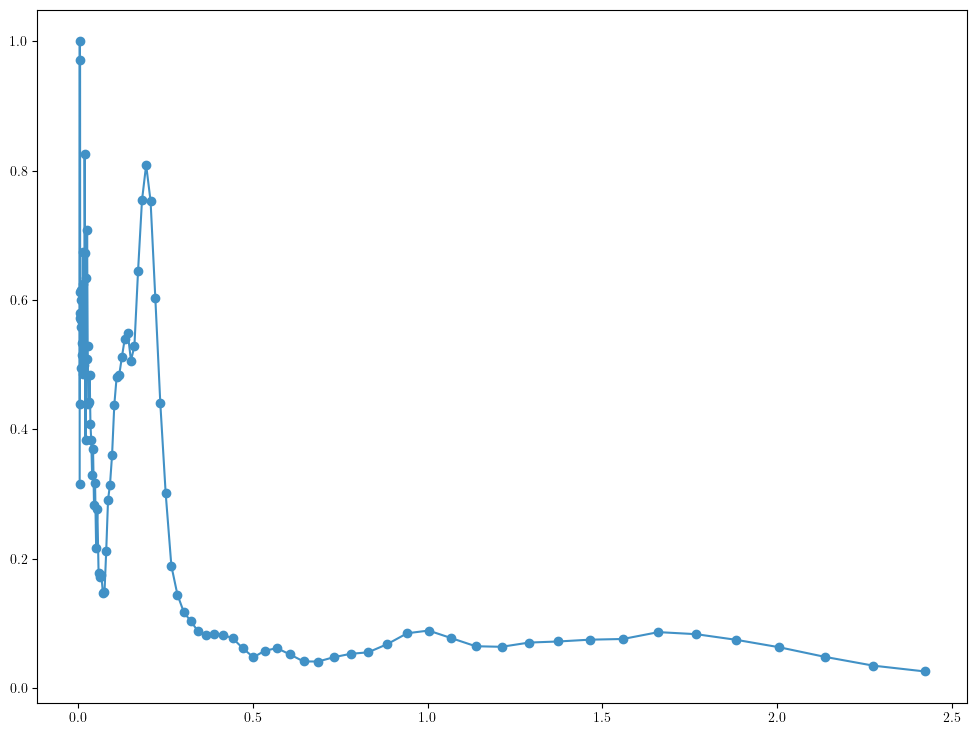

In [158]:
# collect DAS parameters
fs,fiber_length,facq_x = DS.get_DAS_parameters(path2DAS_param,date)

# curvilinear coordinate 
s = np.arange(0,fiber_length,1/facq_x)

CWT = data['mean_CWT']
freq = data['f']

selected_x = 400
idx_x = np.argmin(abs(s - selected_x))

min_prominence = 0.7
min_width = 3

freq_min = 0.05
freq_max = 0.8
idx_min = np.argmin(abs(freq - freq_min))
idx_max = np.argmin(abs(freq - freq_max))

# select a frequency
selected_freq = 0.45
idx_freq = np.argmin(abs(freq - selected_freq))

# define norm for colormaps
norm = colors.Normalize(vmin = freq[idx_min], vmax = freq[idx_max])

# normalize signal
current_cwt_max = np.max(abs(CWT[idx_freq,:,idx_x]))
normalized = abs(CWT[idx_freq,:,idx_x])/current_cwt_max

# find peaks
peaks,properties = scipy.signal.find_peaks(normalized,
                                           prominence = min_prominence,width = min_width)

if len(peaks) != 0:
    p = peaks[0]
    # compute subpixel values
    local_argmax, local_max = subpixel_polyfit(k,normalized,p)
print(peaks)

current_color = new_blues(norm(freq[idx_freq]))

fig, ax = plt.subplots(figsize = (12,9))
ax.plot(k,abs(CWT[idx_freq,:,idx_x])/current_cwt_max,'-o', color = current_color)
ax.plot(k[peaks],normalized[peaks],'r.')
# ax.plot(local_argmax,local_max,'.',color = 'tab:red')


## Extract peaks for all frequencies for a given position

### Collect water depth

In [159]:
file2water = glob.glob(f'{main_path}fiber_water_height_GPS_structure_{date}.h5')[0]
print(file2water)
DAS_water_height = rw.load_dict_from_h5(file2water)
print(DAS_water_height.keys())
# convert UTC string to datetime 
format_date = '%Y-%m-%dT%H-%M-%S.%f'
# convert UTC string to datetime 
DAS_water_height['UTC_datetime'] = []
for date_txt in DAS_water_height['UTC_t']:
    if date_txt != 'None' :
        datetime_obj = datetime.strptime(date_txt,format_date)
        datetime_obj = datetime_obj.replace(tzinfo = pytz.timezone('UTC'))
    # else :
    #     datetime_obj = None
    DAS_water_height['UTC_datetime'].append(datetime_obj)
    
DAS_water_height['UTC_t'] = np.array(DAS_water_height['UTC_datetime'])
del DAS_water_height['UTC_datetime']

U:/Data/0211/DAS/fiber_water_height_GPS_structure_0211.h5
dict_keys(['H', 'UTC_t', 'lat', 'long', 's', 'units', 'water_height'])


In [160]:
format_date = '%Y-%m-%dT%H-%M-%S'
UTC_0 = datetime.strptime(data['label'],format_date)
UTC_0 = UTC_0.replace(tzinfo = pytz.timezone('UTC'))

In [161]:
H = get_water_height(DAS_water_height,UTC_0,selected_x)
print(H)

4.652018916579305


In [162]:
# curvilinear coordinate 
s = np.arange(0,fiber_length,1/facq_x)

CWT = data['mean_CWT']
freq = data['f']

Detected coordinates :[0.06430407 0.07956806 0.08872429 0.10378422 0.11140946 0.12119969
 0.12806257 0.13563523 0.14449618 0.15506609 0.15906918 0.16520955
 0.1701474  0.17432563 0.18017171 0.18417776 0.18774143 0.19416344
 0.19488248 0.19964815 0.20492558 0.19349372 0.20980641 0.21362198
 0.2169584  0.22199551 0.22054128 0.21383604 0.23232473 0.24130832
 0.23960863 0.24309927 0.23900788 0.24760705 0.25106034 0.25992812
 0.25415871 0.26932949]
D = 7.21e+06 ± 1.68e+05
Detected coordinates :[0.06305722 0.07492187 0.08281396 0.09285751 0.09950761 0.11708862
 0.12918566 0.13392408 0.14702037 0.15326739 0.15626994 0.15960356
 0.16704879 0.16969001 0.17418317 0.17938096 0.18243793 0.18543511
 0.18601002 0.18664325 0.1979975  0.18534962 0.19644    0.20296793
 0.20894153 0.20641865 0.20919714 0.21231263 0.21300099 0.21346096
 0.21845784 0.22609998]
D = 9.97e+06 ± 3.99e+05
Detected coordinates :[0.05329897 0.05778505 0.0689579  0.08197012 0.08577337 0.09322424
 0.09453814 0.1051492  0.10873137 

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

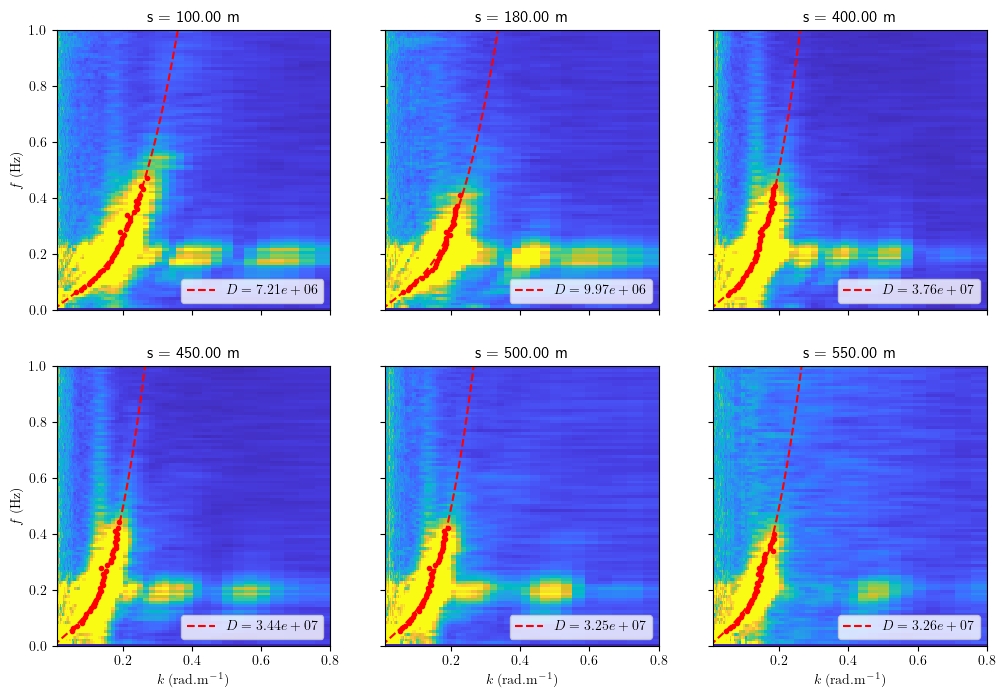

In [164]:
# plot FK with theory 
# select range of frequency within which we look for a peak
freq_range = [0.02,0.8]
min_prominence = 0.7
min_width = 3

k = data['k_star']/np.cos(swell_orientation[date]*np.pi/180)

# select range of k for which we look for a peak
if date in date_downsampling:
    k_min = 0.05
    k_max = 0.8
    idx_kmin = np.argmin(abs(k - k_min))
    idx_kmax = np.argmin(abs(k - k_max))
    CWT = CWT[:,idx_kmax:idx_kmin,:]
    k = k[idx_kmax:idx_kmin]

rho_w = 1027
UTC_mid = UTC_0

selected_x = np.array([100,180,400,450,500,550])
idx_x = [np.argmin(abs(s - x)) for x in selected_x]

fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True,figsize = (12,8))
for i,(ax,idx) in enumerate(zip(axs.flatten(),idx_x)):
    FK = CWT[:,:,idx]
    imsh = ax.pcolormesh(k,freq,abs(FK),cmap = parula_map)
    ax.set_ylim([0,1])
    ax.set_xlim([0.01,0.8])
    # ax.set_ylim([0,8])
    # ax.set_xlim([0,0.7])
    ax.set_title(f's = {s[idx]:.2f} m')
    imsh.set_clim([0,300])
    
    k_exp,f_exp = extract_peaks(FK,freq,k,freq_range,min_prominence,min_width)
    ax.plot(k_exp,f_exp,'r.')
    print(f'Detected coordinates :{k_exp}')
    
    if len(k_exp) != 0:
        H = get_water_height(DAS_water_height,UTC_mid,selected_x[i])
        popt,pcov = scipy.optimize.curve_fit(lambda x,D : shallow_hydroelastic(x, D, rho_w, H)/2/np.pi,k_exp,f_exp,
                                             bounds = (1e5,1e8))
        err_coeff = np.sqrt(np.diag(pcov))
        print(f'D = {popt[0]:.2e} ± {err_coeff[0]:.2e}')
    
        k_th = np.linspace(0,1,100)
        omega_th = shallow_hydroelastic(k_th, popt[0], rho_w, H)
        label_th = r'$D = ' + f'{popt[0]:.2e}' + r'$'
        ax.plot(k_th,omega_th/2/np.pi,'r--',label = label_th)
        ax.legend(loc = 'lower right',fontsize = 10)

for j in range(axs.shape[1]):
    axs[1,j].set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$')

for i in range(axs.shape[0]):
    axs[i,0].set_ylabel(r'$f \; \mathrm{(Hz)}$')   

axs.set_title('With swell orientation correction')

### Without swell orientation correction

Detected coordinates :[0.07872051 0.08710263 0.09884616 0.11165585 0.11672047 0.12977586
 0.13781667 0.142241   0.15184441 0.15778926 0.16182491 0.16460853
 0.17163837 0.17681734 0.18122823 0.1842455  0.18722186 0.18859045
 0.18984132 0.19842988 0.19850824 0.19912729 0.21327226 0.20485043
 0.2144944  0.22405906 0.22047388 0.23095858 0.2247677  0.23383067
 0.22972244 0.24141738 0.24389423 0.24305014 0.24665838 0.24087005
 0.2525811  0.24736968 0.25735773 0.26259827 0.2672646  0.25798402
 0.26381928 0.27647788 0.27107949 0.27834829 0.28263706 0.29015668
 0.29172477 0.30227359 0.29860481]
D = 8.03e+06 ± 1.57e+05
Detected coordinates :[0.06365417 0.07380038 0.08298198 0.08865275 0.10123546 0.10398395
 0.12495405 0.13156172 0.14326996 0.14750407 0.15400983 0.15625732
 0.15978473 0.1665716  0.17108314 0.17431786 0.17796224 0.17872291
 0.18001817 0.18215773 0.1898248  0.18877954 0.19139423 0.20393539
 0.19368803 0.20178555 0.20736085 0.20858658 0.21434483 0.21985566
 0.22182923 0.21859809 0.2

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

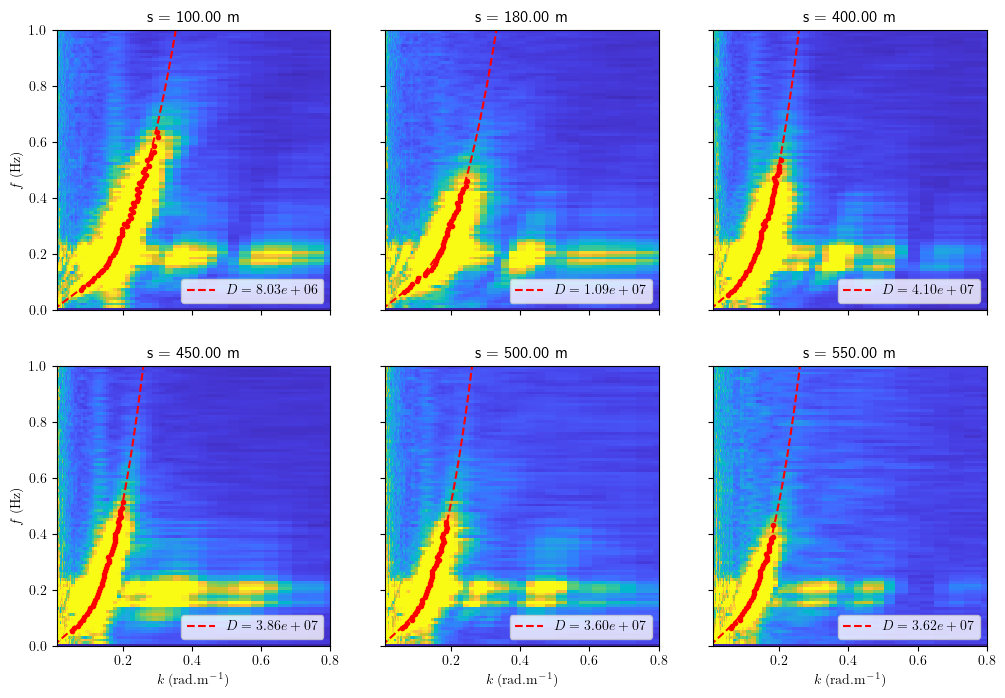

In [138]:
# plot FK with theory 
# select range of frequency within which we look for a peak
freq_range = [0.02,0.8]
min_prominence = 0.7
min_width = 3

k = data['k']
# select range of k for which we look for a peak
if date in date_downsampling:
    k_min = 0.05
    k_max = 0.8
    idx_kmin = np.argmin(abs(k - k_min))
    idx_kmax = np.argmin(abs(k - k_max))
    CWT = CWT[:,idx_kmax:idx_kmin,:]
    k = k[idx_kmax:idx_kmin]

rho_w = 1027
UTC_mid = UTC_0

selected_x = np.array([100,180,400,450,500,550])
idx_x = [np.argmin(abs(s - x)) for x in selected_x]

fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True,figsize = (12,8))
for i,(ax,idx) in enumerate(zip(axs.flatten(),idx_x)):
    FK = CWT[:,:,idx]
    imsh = ax.pcolormesh(k,freq,abs(FK),cmap = parula_map)
    ax.set_ylim([0,1])
    ax.set_xlim([0.01,0.8])
    # ax.set_ylim([0,8])
    # ax.set_xlim([0,0.7])
    ax.set_title(f's = {s[idx]:.2f} m')
    imsh.set_clim([0,300])
    
    k_exp,f_exp = extract_peaks(FK,freq,k,freq_range,min_prominence,min_width)
    ax.plot(k_exp,f_exp,'r.')
    print(f'Detected coordinates :{k_exp}')
    
    if len(k_exp) != 0:
        H = get_water_height(DAS_water_height,UTC_mid,selected_x[i])
        popt,pcov = scipy.optimize.curve_fit(lambda x,D : shallow_hydroelastic(x, D, rho_w, H)/2/np.pi,k_exp,f_exp,
                                             bounds = (1e5,1e8))
        err_coeff = np.sqrt(np.diag(pcov))
        print(f'D = {popt[0]:.2e} ± {err_coeff[0]:.2e}')
    
        k_th = np.linspace(0,1,100)
        omega_th = shallow_hydroelastic(k_th, popt[0], rho_w, H)
        label_th = r'$D = ' + f'{popt[0]:.2e}' + r'$'
        ax.plot(k_th,omega_th/2/np.pi,'r--',label = label_th)
        ax.legend(loc = 'lower right',fontsize = 10)

for j in range(axs.shape[1]):
    axs[1,j].set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$')

for i in range(axs.shape[0]):
    axs[i,0].set_ylabel(r'$f \; \mathrm{(Hz)}$')   

axs.set_title('No swell orientation correction')